In [1]:
import tensorflow as tf
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import warnings
import tqdm
warnings.filterwarnings('ignore')

C:\Users\PLCRCRD19\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading model

In [2]:
# Load graph data
loader = tf.train.import_meta_graph('saved_model/classifier.ckpt.meta')
sess = tf.Session()
loader.restore(sess,'saved_model/classifier.ckpt')
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from saved_model/classifier.ckpt


In [84]:
# Find relevant ops
assert len([op.name for op in graph.get_operations() if 'output' in op.name or 'input' in op.name]) == 2
assert len([op.name for op in graph.get_operations() if 'cnn_' in op.name]) == 0

AssertionError: 

In [6]:
# Grab them
x = graph.get_tensor_by_name('features:0')
y = graph.get_tensor_by_name('output:0')

# Testing model accuracy (just in case)

In [7]:
test_image = skimage.transform.resize(plt.imread('train/dog.0.jpg'), (128,128,1))
res = sess.run(y, feed_dict={x: [test_image]})
answer = 'cat' if res[0][0]>res[0][1] else 'dog'
print(f'{res[0]} - {answer}')

[0.42274418 0.5772558 ] - dog


In [8]:
def calculate_accuracy():
    counter = 0
    for i in tqdm.trange(1000):
        animal = 'cat' if i%2==0 else 'dog'
        test_image = skimage.transform.resize(plt.imread(f'train/{animal}.{i}.jpg'), (128,128,1))
        res = sess.run(y, feed_dict={x: [test_image]})
        answer = 'cat' if res[0][0]>res[0][1] else 'dog'
        if answer == animal:
            counter+=1
    return counter
      
counter = calculate_accuracy()
print(f'{counter/10}% accuracy')

100%|██████████████████████████████████████| 1000/1000 [00:21<00:00, 46.69it/s]


67.5% accuracy


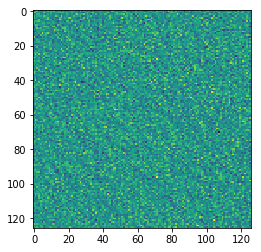

In [22]:
def T(layer):
    return graph.get_tensor_by_name(f'{layer}:0')

inp = T('cnn/classificator/convolution/deep_dreaming_input/Conv2D')

img = np.random.uniform(size=(1,128,128,3)) + 100.0
res = sess.run(T('cnn/classificator/convolution/conv2d/Conv2D'), feed_dict={inp: img})
# res.T.shape
res = res/np.max(res)
plt.imshow(res[0,:,:,3])

# Dreaming!

In [12]:
print([op.name for op in graph.get_operations() if 'Conv2D' in op.name and 'training' not in op.name])
# print([op.name for op in graph.get_operations() if 'output' in op.name and 'training' not in op.name])

['cnn/classificator/convolution/deep_dreaming_input/Conv2D', 'cnn/classificator/convolution/conv2d/Conv2D', 'cnn/classificator/convolution/conv2d_1/Conv2D', 'cnn/classificator/convolution/conv2d_2/Conv2D', 'cnn/classificator/convolution/conv2d_3/Conv2D', 'cnn/classificator/convolution/conv2d_4/Conv2D']


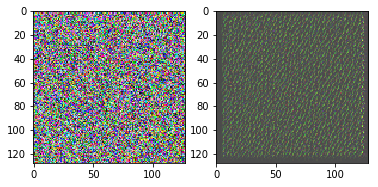

In [81]:
layer = 'cnn/classificator/convolution/conv2d_1/Conv2D'
feature = 2

# np.random.seed(0)
img_noise = np.random.random(size=(1,128,128,3))

def showarray(a, fmt='jpeg'):
    a = a/np.max(a)
    plt.imshow(a[0])
    
def norm(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def replace_none_with_zero(l):
    return [0 if i==None else i for i in l] 

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, inp)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {inp:img})
        
        g /= g.std()+1e-8         
        img += g*step
#         print(score)
    showarray(norm(img))
        
    return img

op = T(layer)
plt.subplot(121)
plt.imshow(img_noise[0])
plt.subplot(122)
img = render_naive(op[:,:,:,feature])

In [174]:
def dream_image(img0, t_obj, feature, iter_n=20, step=1.0, bw=False, random=False):
    entry_point = x if bw else inp
    if random and bw:
        img0 = np.random.random(size=(1,128,128,1))
    elif random:
        img0 = np.random.random(size=(1,128,128,3))
    
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, entry_point)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {entry_point:img})
        
        g /= g.std()+1e-8         
        img += g*step
        
    return img/np.max(img)

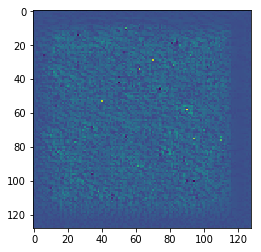

In [186]:
img = dream_image(None, T('cnn/classificator/convolution/conv2d_2/Conv2D'), 20, random=True, bw=True)
plt.imshow(img[0,:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


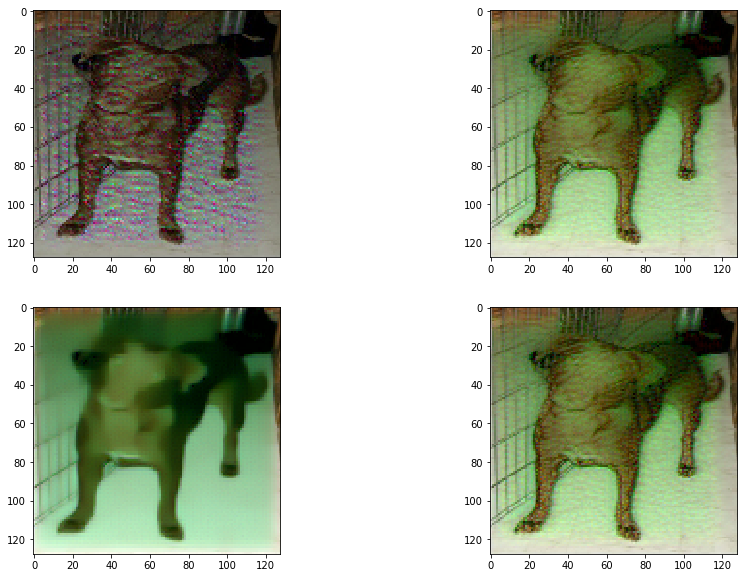

In [195]:
img = plt.imread(f'train/dog.1.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_3/Conv2D'), 5, step=0.01)[0])
plt.subplot(222)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 20, step=0.01)[0])
plt.subplot(223)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_1/Conv2D'), 20, step=0.01)[0])
plt.subplot(224)
plt.imshow(dream_image([img], T('cnn/classificator/convolution/conv2d_2/Conv2D'), 40, step=0.01)[0])

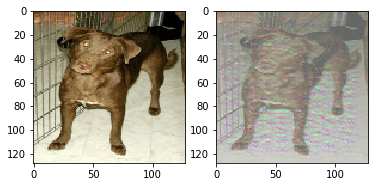

In [121]:
img = plt.imread(f'train/dog.1.jpg')
img = skimage.transform.resize(img, (128, 128, 3))
img = img/np.max(img)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
dream_image([img], 'cnn/classificator/convolution/conv2d_3/Conv2D', 30, iter_n=20, step=0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


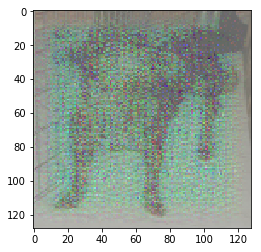

In [131]:
dream_image([img], 'cnn/classificator/convolution/conv2d_2/Conv2D', 20, iter_n=20, step=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0.26894143, 0.7310586 ]], dtype=float32)

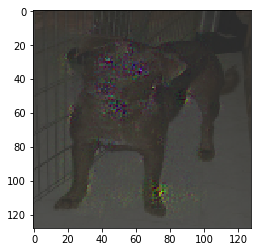

In [144]:
op = T('output')
purified = render_naive(op[:,1], img0=[img], iter_n=300, step=0.1);
sess.run(y, {inp:purified})

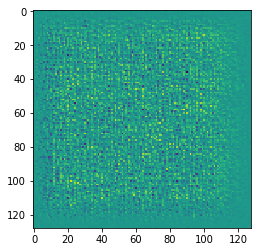

In [153]:
t_obj = T('cnn/classificator/convolution/conv2d_2/Conv2D')[:,:,:,3]
t_score = tf.reduce_mean(t_obj)
t_grad = tf.gradients(t_obj, x)[0]

img_noise = np.random.random(size=(1,128,128,1))

for i in range(20):
    g, score = sess.run([t_grad, t_score], {x:img_noise})

    g /= g.std()+1e-8         
    img_noise += g*1.0

showarray(norm(img_noise)[:,:,:,0])